In [1]:
# Data processing
# ===============================
import pandas as pd
# Graphics
# ===============================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Modeling and Forecasting
# ===============================
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
# Metrics
# ===============================
from sklearn.metrics import mean_absolute_error

In [2]:
# mute Pandas warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Get to know the data

## Loading the  ETTh1 dataset

In [3]:
path = "ETTh1.csv"
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.drop("Id", axis=1, inplace=True)
df = df.asfreq('H')
df = df.sort_index()
df.head()

,OT
date,
2016-07-01 00:00:00,30.531000
2016-07-01 01:00:00,27.787001
2016-07-01 02:00:00,27.787001
2016-07-01 03:00:00,25.044001
2016-07-01 04:00:00,21.948000


In [4]:
df.tail()

,OT
date,
2018-06-22 11:00:00,6.753
2018-06-22 12:00:00,3.658
2018-06-22 13:00:00,3.658
2018-06-22 14:00:00,4.150
2018-06-22 15:00:00,4.643


In [5]:
print(f"length of dataset in days {(df.tail(1).index - df.head(1).index).days.values}")
print(f"length of dataset in months {(df.tail(1).index - df.head(1).index).days.values/30}")
print(f"length of dataset in years {(df.tail(1).index - df.head(1).index).days.values/365}")

length of dataset in days [721]
length of dataset in months [24.03333333]
length of dataset in years [1.97534247]


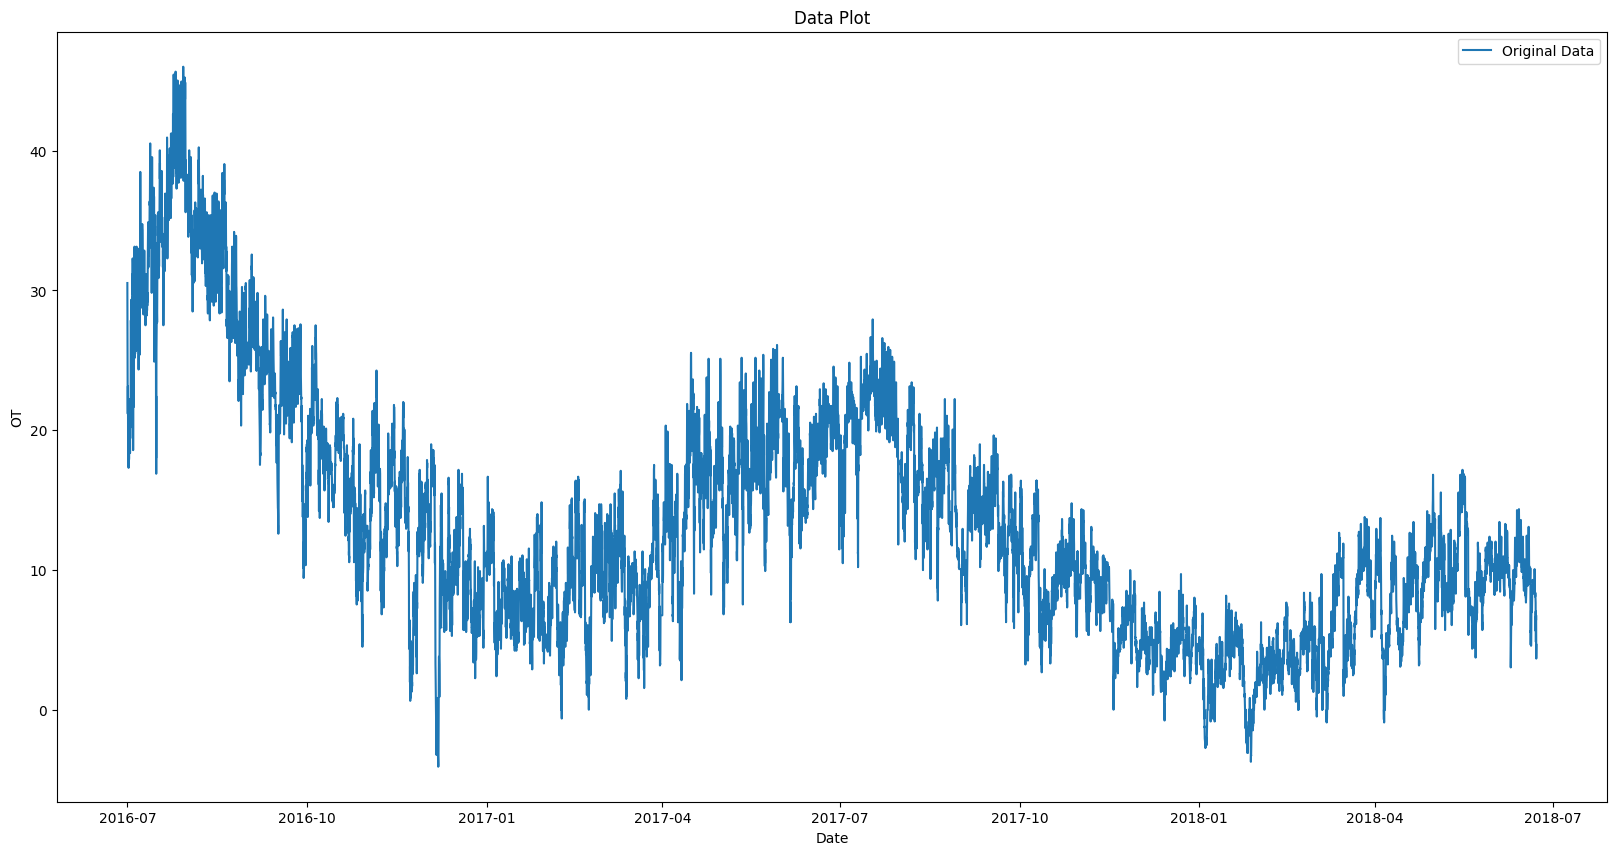

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(df, label='Original Data')
plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Data Plot')
plt.legend()
plt.show()

## Seasonality

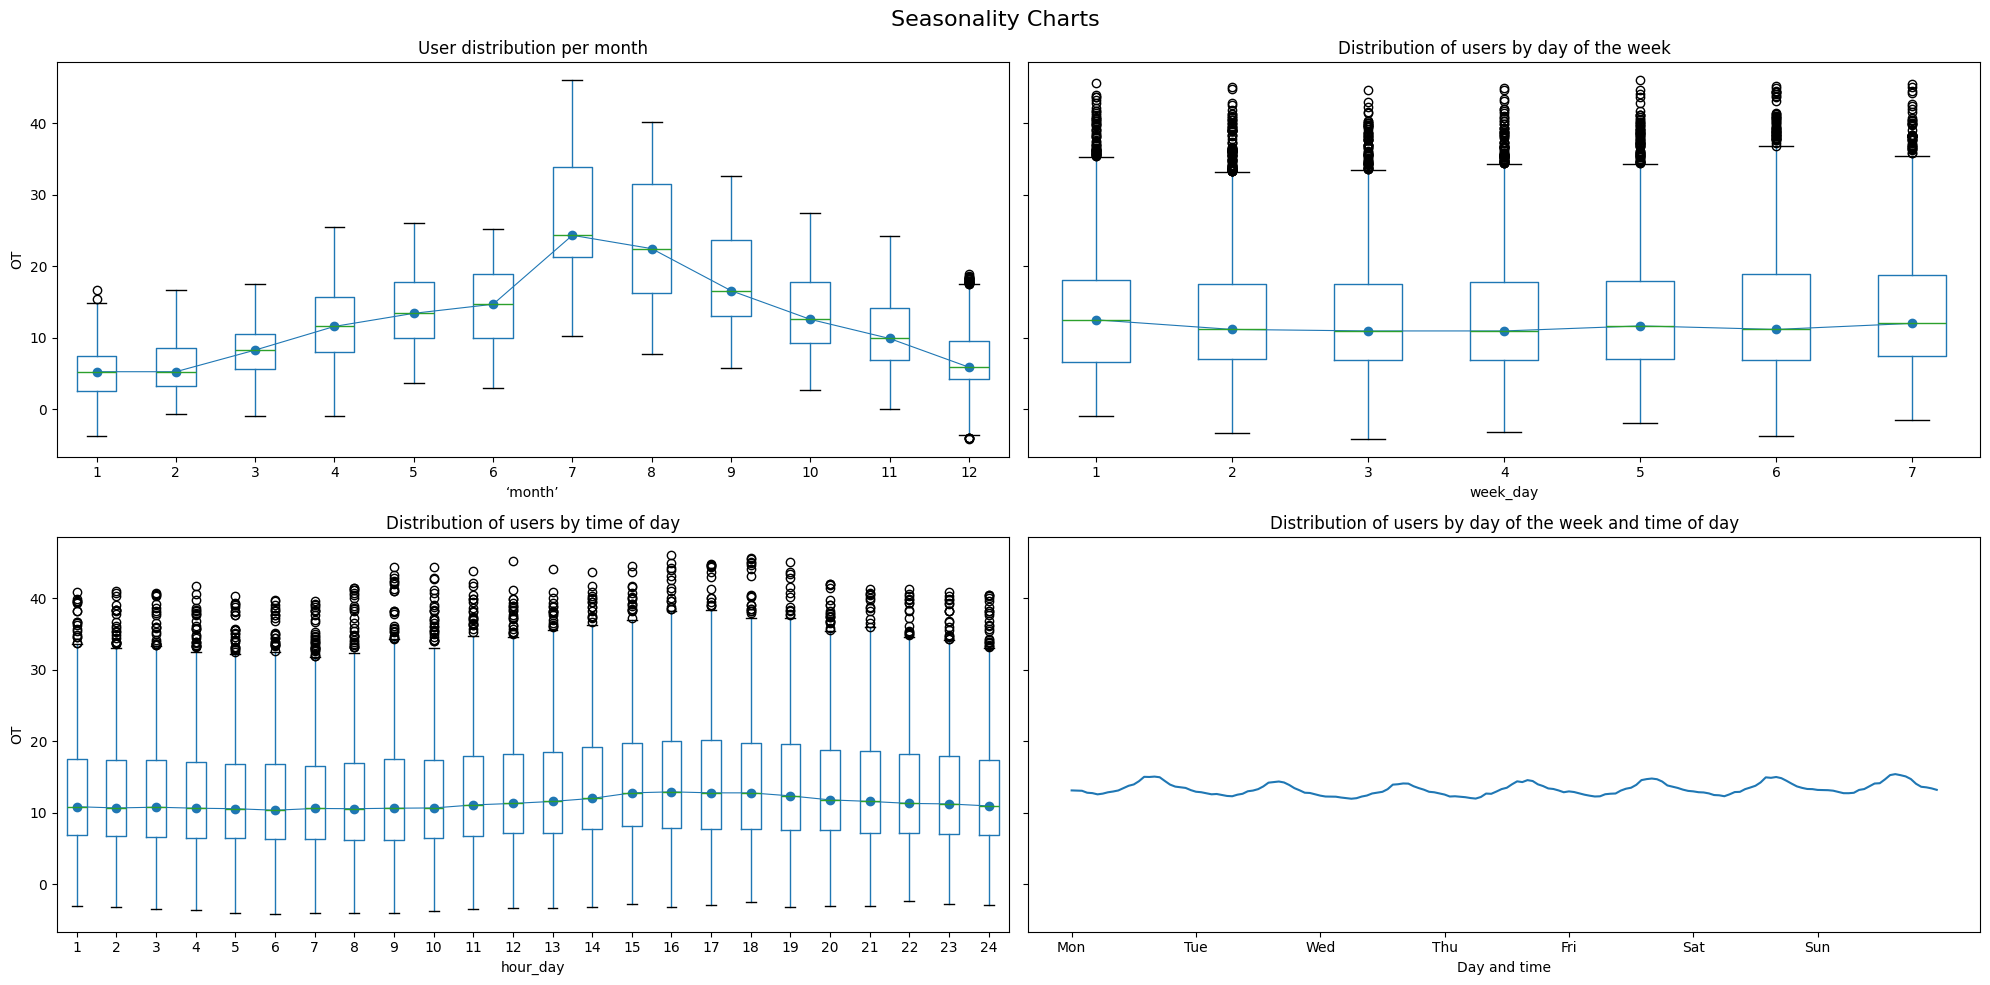

In [7]:
# ===============================
data = df.copy()
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=False, sharey=True)
axs = axs.ravel()

# User distribution by month
data['‘month’'] = data.index.month
data.boxplot(column='OT', by='‘month’', ax=axs[0])
data.groupby('‘month’')['OT'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('OT')
axs[0].set_title('User distribution per month')

# User distribution by day of the week
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='OT', by='week_day', ax=axs[1])
data.groupby('week_day')['OT'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('OT')
axs[1].set_title('Distribution of users by day of the week')

# Distribution of users by time of day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='OT', by='hour_day', ax=axs[2])
data.groupby('hour_day')['OT'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('OT')
axs[2].set_title('Distribution of users by time of day')

# Distribution of users by day of the week and time of day
mean_day_hour = data.groupby(["week_day", "hour_day"])["OT"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set_ylabel('OT')
axs[3].set_title('Distribution of users by day of the week and time of day')
axs[3].set_xticks([i * 24 for i in range(7)])
axs[3].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
axs[3].set_xlabel('Day and time')


fig.suptitle("Seasonality Charts", fontsize=16)
fig.tight_layout()

#### Comments
- there is a yearly (summer/winter) and daily (day/night) effect on the oil of the Transformer "OT" which can be interpreted by assuming that the environment (outside/building) that the transporter is located in effects the OT

## Correlation

<Figure size 1000x400 with 0 Axes>

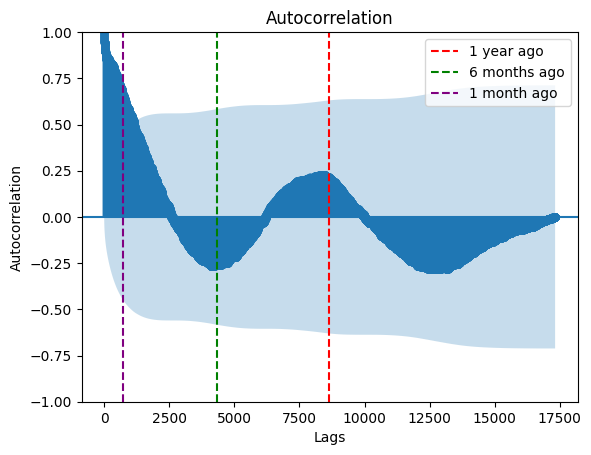

In [8]:
# Autocorrelation graph
# ===============================
plt.figure(figsize=(10, 4))
plot_acf(data["OT"], lags=len(data)-1)
plt.axvline(x=24*30*12, color='red', linestyle='--', label='1 year ago')
plt.axvline(x=24*30*6, color='green', linestyle='--', label='6 months ago')
plt.axvline(x=24*30*1, color='purple', linestyle='--', label='1 month ago')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

<Figure size 1000x400 with 0 Axes>

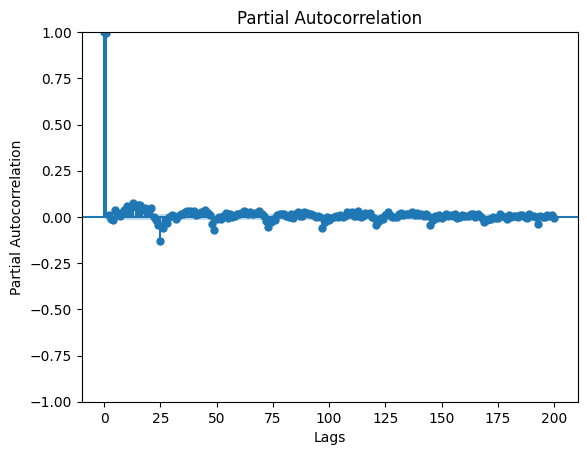

In [9]:
# Partial autocorrelation graph
# ===============================
plt.figure(figsize=(10, 4))
plot_pacf(data['OT'], lags=200)
plt.ylabel('Partial Autocorrelation')
plt.xlabel('Lags')
plt.show()

#### Comments:

- the high correlation with the last previous hours is very logical since the temperature of the next hour would be most likely close to the current temperature


## ZOOM IN

plot 4 days 

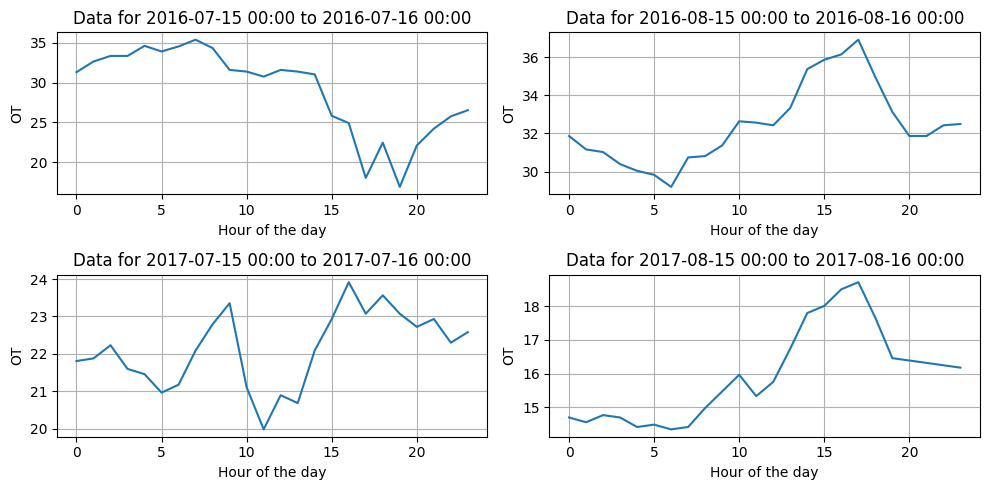

In [10]:

# Create a list of start dates with minutes and hours
start_dates = ['2016-07-15 00:00', '2016-08-15 00:00', '2017-07-15 00:00', '2017-08-15 00:00 00:00']
plt.figure(figsize=(10, 5))
# Loop through the start dates
for start_date in start_dates:
    plt.subplot(2, 2,start_dates.index(start_date)+1)
    start_date_time = pd.to_datetime(start_date)
    end_date_time = start_date_time + pd.DateOffset(hours=24)
    # Subset the data for the next 24 hours
    day_data = df[(df.index >= start_date_time) & (df.index < end_date_time)]
    # Plot the data
    plt.plot(range(24),day_data["OT"])
    plt.xlabel('Hour of the day')
    plt.ylabel('OT')
    plt.title('Data for ' + start_date_time.strftime('%Y-%m-%d %H:%M') + ' to ' + end_date_time.strftime('%Y-%m-%d %H:%M'))
    plt.grid(True)
    

plt.tight_layout()
plt.show()

#### Comments:

Beyond the two basic yearly and daily seasonality, "OT" variable seem to fluctuate a lot. Which suggest that there are other factors beside the environment temperature that effects the OT:
- __Transformer Load Variations__: Changes in the electrical load on the transformer can lead to fluctuations in temperature.
- __Transient Events__: Transient events, such as switching operations, fault conditions, or external disturbances.
- __Maintenance__: Regular maintenance, including oil testing, filtration, and purification can effect the oil temperature. 
- __Internal Transformer Dynamics__: Complex interactions within the transformer, such as thermal gradients, oil circulation patterns, and heat dissipation from 
  different components.

  Our best hope is that our model can catch some of patterns which are within our data, but we should not expect a "great" forecasting result since a lot of the things are simply not known of us which are generated from a stochastic process.

## Split data into train/test

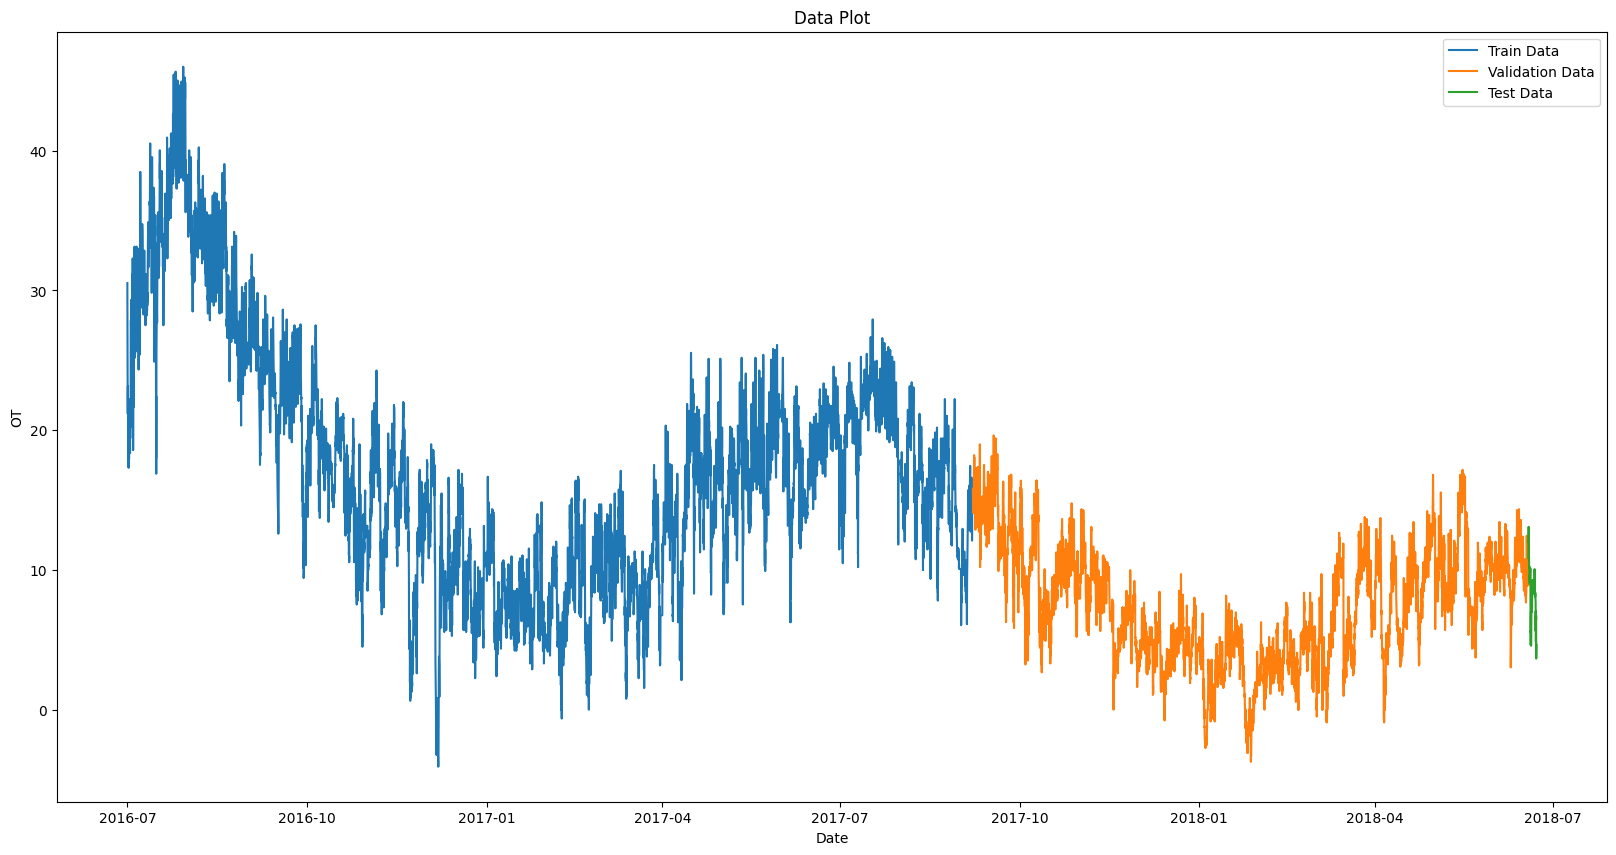

In [11]:
data = df.copy()
# Split data into train and test sets
train_size = int(len(data) * 0.6) # 50% train, 50% validation - 100, 100 test
train_val_data = data.iloc[:-100].copy()
train_data = data.iloc[:train_size].copy()
val_data = data.iloc[train_size:-100].copy()
test_data = data.iloc[-100:].copy()

plt.figure(figsize=(20, 10))
plt.plot(train_data, label='Train Data')
plt.plot(val_data, label='Validation Data')
plt.plot(test_data, label='Test Data')
plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Data Plot')
plt.legend()
plt.show()

In [12]:
print(f"Train data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 10392
Validation data length: 6828
Test data length: 100


# Baseline

  Create baseline naive forecasters that take the temperature that was measuredl

  - a year ago
  - 6 months ago
  - a month ago
  - 2 weeks ago
  - 24 hours ago

In [13]:
forecasters = {"Baseline year": ForecasterEquivalentDate(offset=pd.DateOffset(days=365), n_offsets=1),
                "Baseline 6months": ForecasterEquivalentDate(offset=pd.DateOffset(days=30*6), n_offsets=1),
                "Baseline 100day": ForecasterEquivalentDate(offset=pd.DateOffset(days=100), n_offsets=1),
                "Baseline month": ForecasterEquivalentDate(offset=pd.DateOffset(days=30), n_offsets=1),
                "Baseline 2weeks": ForecasterEquivalentDate(offset=pd.DateOffset(days=14), n_offsets=1),
                "Baseline 24hours": ForecasterEquivalentDate(offset=pd.DateOffset(days=1), n_offsets=1),}

## Results on Validation data

In [14]:

len(train_data),len(val_data)

(10392, 6828)

In [15]:
# training
for name, forecaster in forecasters.items():
    forecaster.fit(y=train_data["OT"])
results = {}
best = float("inf")
# prediction
for name, forecaster in forecasters.items():
    predictions = forecaster.predict(steps=len(val_data))
    results[name] = predictions
    mae = mean_absolute_error(val_data["OT"], predictions)
    print(f"{name} validation error (MAE): {mae}")
    if mae < best:
        best = mae
        best_forecaster = name
print(f"Best forecaster: {best_forecaster}")


Baseline year validation error (MAE): 6.571686585072935
Baseline 6months validation error (MAE): 9.666169011498535
Baseline 100day validation error (MAE): 10.989338304536906
Baseline month validation error (MAE): 7.795563288231986
Baseline 2weeks validation error (MAE): 6.722801260173843
Baseline 24hours validation error (MAE): 8.130498764978178
Best forecaster: Baseline year


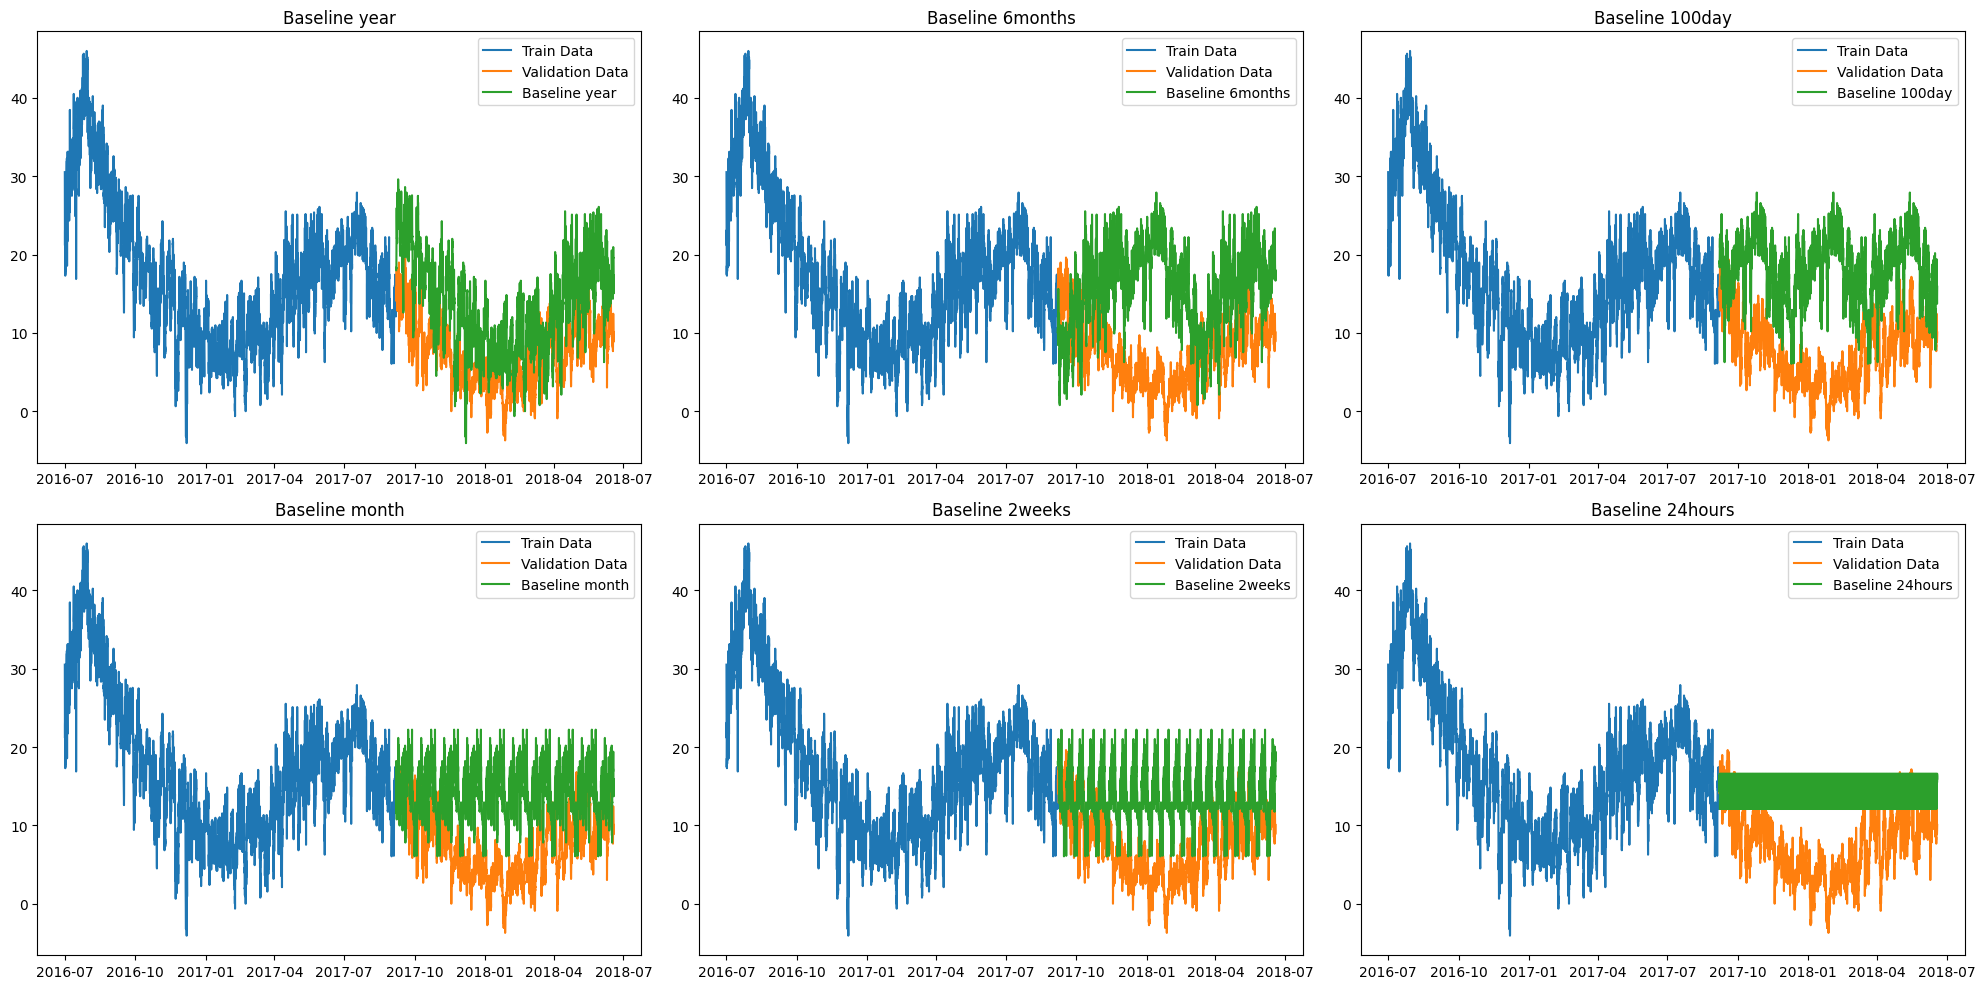

In [16]:

plt.figure(figsize=(20, 10))

# Iterate over the items in the results dictionary
for name, predictions in results.items():
    # Create a new subplot for each item
    plt.subplot(2, 3, list(results.keys()).index(name) + 1)
    
    # Plot the train data
    plt.plot(train_data, label='Train Data')
    
    # Plot the validation data
    plt.plot(val_data, label='Validation Data')
    
    # Plot the predictions for the current item
    plt.plot(val_data.index, predictions, label=name)
    
    # Set the title for the subplot
    plt.title(name)
    
    # Add a legend to the subplot
    plt.legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

#### We can see that the yearly baseline is the best and in fact, if we move it a bit down it well be a very good forecasting result!. The OT was a bit hotter in the train set.

Its seems that a model that uses tha value of last year and just take into account the global trend that this year is is hotter/colder than last one. and adjust the prediction based on this comparison.

Lets subtract some temperature to see if we match the validation set:

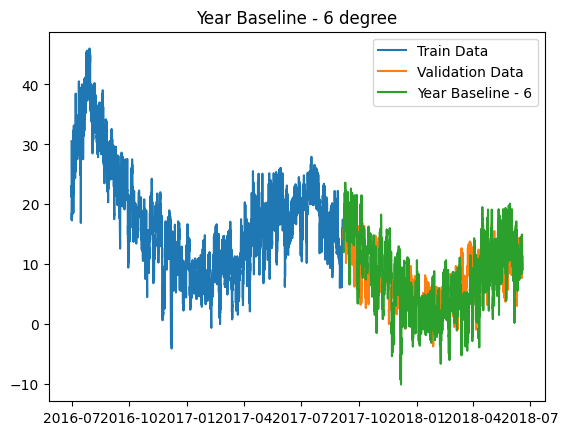

In [17]:
to_subtract = 6
year_preds_val = results['Baseline year'] - to_subtract
# Plot the train data
plt.plot(train_data, label='Train Data')    
# Plot the validation data
plt.plot(val_data, label='Validation Data')

# Plot the predictions for the current item
plt.plot(val_data.index, year_preds_val, label=f"Year Baseline - {to_subtract}")

# Set the title for the subplot
plt.title(f"Year Baseline - {to_subtract} degree")

# Add a legend to the subplot
plt.legend()

In [18]:
mse = mean_absolute_error(val_data["OT"], year_preds_val)
print(f"Year Baseline -{to_subtract} val error (MAE): {mse}")

Year Baseline -6 val error (MAE): 3.7586903947975987


## results on test data 

Now, we test the basic models on our last 100 hour!


In [19]:
# training
for name, forecaster in forecasters.items():
    forecaster.fit(y=train_val_data["OT"])
results = {}
best = float('inf')
# prediction
for name, forecaster in forecasters.items():
    predictions = forecaster.predict(steps=len(test_data))
    results[name] = predictions
    mae = mean_absolute_error(test_data["OT"], predictions)
    print(f"{name} test error (MAE): {mae}")
    if mae < best:
        best = mae
        best_forecaster = name
print(f"Best forecaster: {best_forecaster}")

Baseline year test error (MAE): 11.039579987719998
Baseline 6months test error (MAE): 3.1888000152399996
Baseline 100day test error (MAE): 2.3762499753900004
Baseline month test error (MAE): 2.3157700083699995
Baseline 2weeks test error (MAE): 2.2707699815500004
Baseline 24hours test error (MAE): 1.9380200336200002
Best forecaster: Baseline 24hours


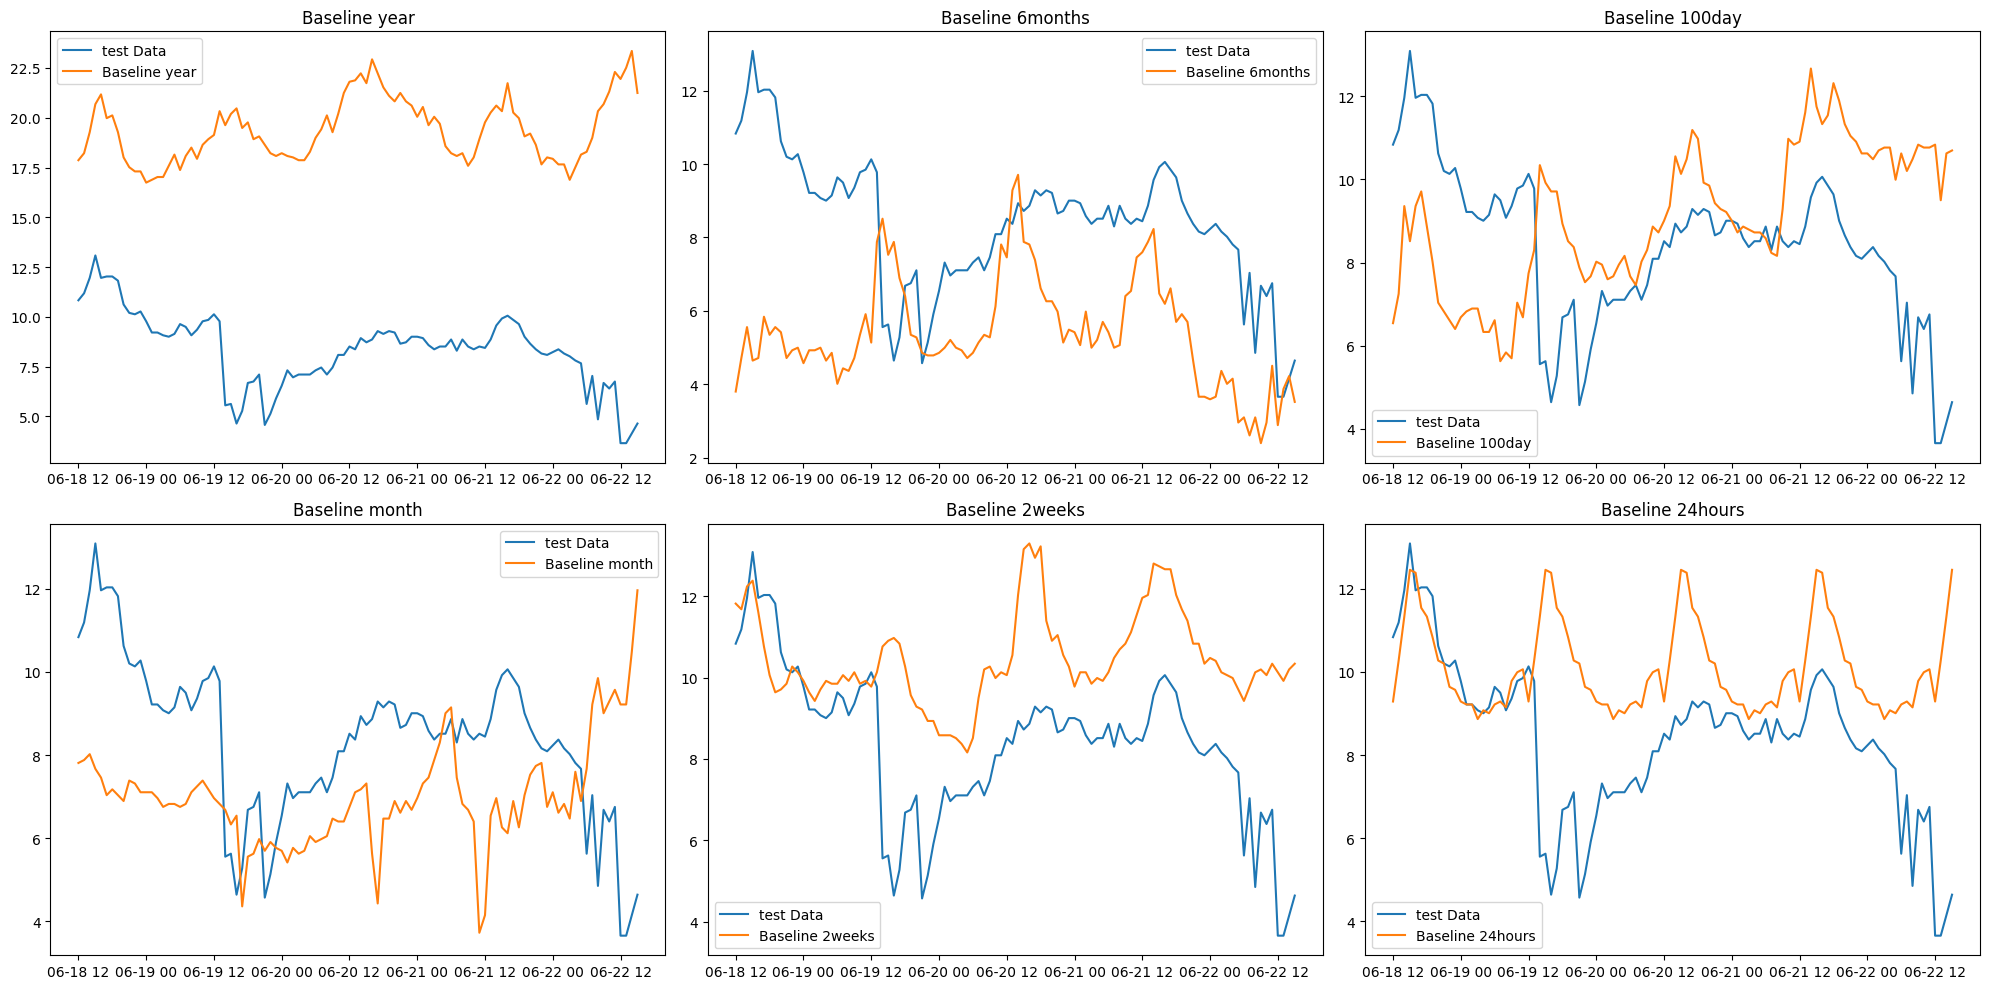

In [20]:

plt.figure(figsize=(20, 10))

# Iterate over the items in the results dictionary
for name, predictions in results.items():
    # Create a new subplot for each item
    plt.subplot(2, 3, list(results.keys()).index(name) + 1)
    
    # Plot the validation data
    plt.plot(test_data, label='test Data')
    
    # Plot the predictions for the current item
    plt.plot(test_data.index, predictions, label=name)
    
    # Set the title for the subplot
    plt.title(name)
    
    # Add a legend to the subplot
    plt.legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

Surprisingly, our yearly model scored the worst! even though we know it was the model for the validation set which was much much larger, and the 24Hour one got the first place. lets try to subtract some degrees maybe we can archive some good results:

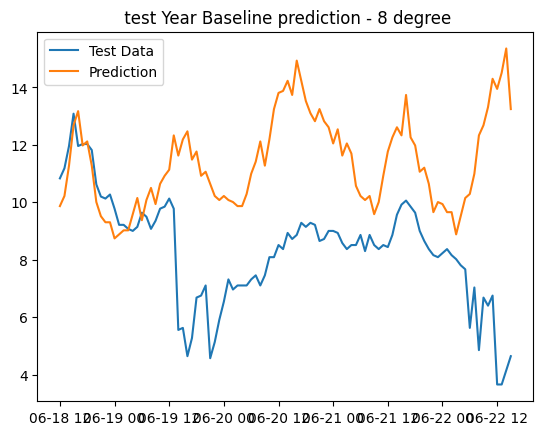

In [23]:
to_subtract = 8
year_preds_val = results['Baseline year'] - to_subtract
# Plot the test data
plt.plot(test_data, label='Test Data')    
plt.plot(year_preds_val,label="Prediction")
# Set the title for the subplot
plt.title(f" test Year Baseline prediction - {to_subtract} degree")
# Add a legend to the subplot
plt.legend()

In [24]:
mse = mean_absolute_error(test_data["OT"], year_preds_val)
print(f"Year Baseline -{to_subtract} test error (MAE): {mse}")

Year Baseline -8 test error (MAE): 3.2109599920800003


Even after adjusting the yearly prediction. it is still the __worst__ . It may seem that a better "general" forecaster does not mean that it will preform better at forecasting short durations as the next 100 hour. We need to experiment with actual Statistical and/or more ML oriented models.

ps: some possible explanations:
- The external factors (that are not included in our data) which we talked about in a previous section that are random (we treat them as such since they are external and we have no idea how to model them) just make the task of predicting short duration very hard
- the test set is unusual (which I doubt since the the external factors seem more likely and most of the dataset is just that noisy)
- this basic models lack feature of capturing some extent and presence of the external factors in our "OT" variable 